In [1]:
import re
import pandas as pd
import torch
import fastai
from fastai.text import *
from fastai.text.data import *
from fastai.data_block import *
import torch.nn as nn
from collections import Counter

%reload_ext autoreload
%autoreload 1

In [2]:

from pair_classification.ulmfit.data import PairTextList
from pair_classification.ulmfit.learner import text_classifier_learner, PairAttentionPoolingDSSMFC1Classifier

In [3]:
DATA_FOLDER = './data/'
LM_FOLDER = './models/ulmfit/'

TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
CLF_FOLDER = './models/ulmfit/'


In [4]:
train_df = pd.read_csv(DATA_FOLDER + TRAIN_CSV)
test_df = pd.read_csv(DATA_FOLDER + TEST_CSV)

In [5]:
train_df = train_df.fillna('')
test_df = test_df.fillna('')

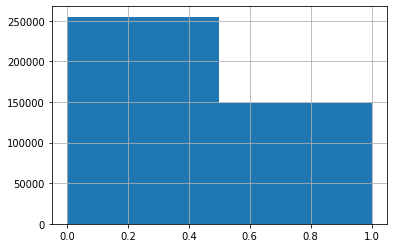

In [6]:
train_df['is_duplicate'].hist(bins=2)

In [7]:
question_counter = Counter(train_df['qid1'].value_counts().to_dict()) + Counter(train_df['qid2'].value_counts().to_dict())
print(len(question_counter))
question_counter.most_common(10)

537933


[(2559, 157),
 (30782, 120),
 (4044, 111),
 (2561, 88),
 (14376, 79),
 (17978, 77),
 (2675, 68),
 (28764, 66),
 (1772, 63),
 (24555, 61)]

## Pair Classification

In [8]:
data_list_clas = PairTextList.from_df(train_df, vocab=Vocab.load(LM_FOLDER + '/unlabeled_vocab'), col1=3, col2=4)\
                   .split_by_rand_pct(valid_pct=0.15, seed=33)\
                   .label_from_df(cols='is_duplicate')

In [25]:
data_clas = data_list_clas.databunch()
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM, path=CLF_FOLDER, clf_class=PairAttentionPoolingDSSMFC1Classifier)

In [26]:
learn_clas.load_encoder('../unlabeled_lm_unfreeze_4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.62E-03


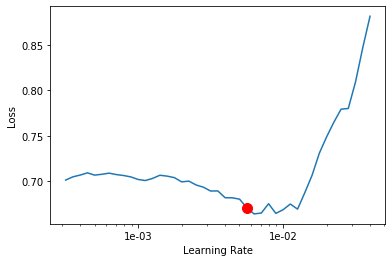

In [27]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(skip_end=10, suggestion=True)
best_clf_lr = learn_clas.recorder.min_grad_lr


In [28]:
div_factor = 2.6
lr_list = [best_clf_lr / div_factor**4, 
           best_clf_lr / div_factor**3, 
           best_clf_lr / div_factor**2, 
           best_clf_lr / div_factor, 
           best_clf_lr]

In [29]:
learn_clas.fit_one_cycle(1, best_clf_lr)
learn_clas.save('pair_clf_freezed')

epoch,train_loss,valid_loss,accuracy,time
0,0.491312,0.441305,0.783833,10:13


In [30]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, lr_list)
learn_clas.save('pair_clf_unfreezed_2')


epoch,train_loss,valid_loss,accuracy,time
0,0.443907,0.412382,0.803737,11:38


In [ ]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, lr_list)
learn_clas.save('pair_clf_unfreezed_3')

epoch,train_loss,valid_loss,accuracy,time


In [35]:
v = learn_clas.validate()

In [36]:
v

[0.39473698, tensor(0.8153)]

In [37]:
learn_clas.freeze_to(-4)
learn_clas.fit_one_cycle(1, lr_list)
learn_clas.save('pair_clf_unfreezed_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.397121,0.381577,0.825767,23:52


In [38]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, lr_list)
learn_clas.save('pair_clf_unfreezed_full')

epoch,train_loss,valid_loss,accuracy,time
0,0.347151,0.370278,0.833484,28:11


In [66]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, lr_list)
learn_clas.save('pair_clf_unfreezed_full_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.367022,0.369602,0.829411,28:26


In [67]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, lr_list)
learn_clas.save('pair_clf_unfreezed_full_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.388322,0.387168,0.826394,28:10


## Submission

In [51]:
data_clas.add_test(test_df[['question1', 'question2']])


In [52]:
data_clas.dl

<bound method DataBunch.dl of PairTextClasDataBunch;

Train: LabelList (343647 items)
x: PairTextList
[Text xxbos xxmaj what is the step by step guide to invest in share market in india ?, Text xxbos xxmaj what is the step by step guide to invest in share market ?],[Text xxbos xxmaj what is the story of xxmaj kohinoor ( xxmaj koh - i - xxmaj noor ) xxmaj diamond ?, Text xxbos xxmaj what would happen if the xxmaj indian government stole the xxmaj kohinoor ( xxmaj koh - i - xxmaj noor ) diamond back ?],[Text xxbos xxmaj how can i increase the speed of my internet connection while using a xxup vpn ?, Text xxbos xxmaj how can xxmaj internet speed be increased by hacking through xxup dns ?],[Text xxbos xxmaj why am i mentally very lonely ? xxmaj how can i solve it ?, Text xxbos xxmaj find the remainder when [ xxunk } [ / math ] is divided by xxunk ?],[Text xxbos xxmaj which one dissolve in water xxunk sugar , salt , methane and carbon di oxide ?, Text xxbos xxmaj which fish would survive in

In [53]:
test_preds, _ = learn_clas.get_preds(DatasetType.Test, ordered=True)

In [54]:
learn_clas.predict(test_df.iloc[1])

(Category 0, tensor(0), tensor([[0.9497, 0.0503]]))

In [65]:
print(test_df.iloc[23]['question1'])
print(test_df.iloc[23]['question2'])
print(test_preds[23])

I want to eat hacking where should I start?
If I want to learn processor what should I do?
tensor([[0.4341, 0.5659]])


In [56]:
test_df['is_duplicate'] = test_preds.data.cpu().numpy()[:,0, 1]

In [57]:
test_preds.data.cpu().numpy().shape

(2345796, 1, 2)

In [58]:
test_df

,test_id,question1,question2,is_duplicate
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0.083556
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0.122983
2,2,What but is the best way to send money from Ch...,What you send money to China?,0.055723
3,3,Which food not emulsifiers?,What foods fibre?,0.104749
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0.414826
...,...,...,...,...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?,0.011364
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?,0.028532
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?,0.008066
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...,0.006230


In [59]:
test_df[['test_id', 'is_duplicate']].to_csv('models/ulmfit/ulmfit_predictions.csv', index=False, header=True)

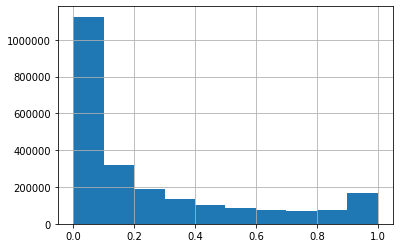

In [62]:
test_df['is_duplicate'].hist()